In [1]:
import numpy as np
from scipy.sparse import kron, identity
from scipy.sparse.linalg import eigsh 

class Block:
    def __init__(self, length, basis_size, operator_dict):
        self.length = length
        self.basis_size = basis_size
        self.operator_dict = operator_dict

class EnlargedBlock:
    def __init__(self, length, basis_size, operator_dict):
        self.length = length
        self.basis_size = basis_size
        self.operator_dict = operator_dict

def is_valid_block(block):
    return all(op.shape == (block.basis_size, block.basis_size) for op in block.operator_dict.values())

is_valid_enlarged_block = is_valid_block

model_d = 2  # Single-site basis size

Sz1 = np.array([[0.5, 0], [0, -0.5]], dtype='d')  # Single-site S^z
Sp1 = np.array([[0, 1], [0, 0]], dtype='d')  # Single-site S^+
H1 = np.array([[0, 0], [0, 0]], dtype='d')  # Single-site portion of H is zero

def H2(Sz1, Sp1, Sz2, Sp2):
    J, Jz = 1., 1.
    return (J / 2) * (kron(Sp1, Sp2.T.conj()) + kron(Sp1.T.conj(), Sp2)) + Jz * kron(Sz1, Sz2)

initial_block = Block(1, model_d, {"H": H1, "conn_Sz": Sz1, "conn_Sp": Sp1})

def enlarge_block(block):
    mblock = block.basis_size
    o = block.operator_dict

    enlarged_operator_dict = {
        "H": kron(o["H"], identity(model_d)) + kron(identity(mblock), H1) + H2(o["conn_Sz"], o["conn_Sp"], Sz1, Sp1),
        "conn_Sz": kron(identity(mblock), Sz1),
        "conn_Sp": kron(identity(mblock), Sp1),
    }

    return EnlargedBlock(block.length + 1, block.basis_size * model_d, enlarged_operator_dict)

def rotate_and_truncate(operator, transformation_matrix):
    T_conj_transpose = transformation_matrix.T.conj()
    return T_conj_transpose @ operator @ transformation_matrix

In [2]:
def enlarge_blocks(sys, env):
    """Enlarge system and environment blocks."""
    sys_enl = enlarge_block(sys)
    env_enl = enlarge_block(env) if sys is not env else sys_enl
    return sys_enl, env_enl

def construct_superblock_hamiltonian(sys_enl, env_enl):
    """Construct the full superblock Hamiltonian."""
    return kron(sys_enl.operator_dict["H"], identity(env_enl.basis_size)) + \
           kron(identity(sys_enl.basis_size), env_enl.operator_dict["H"]) + \
           H2(sys_enl.operator_dict["conn_Sz"], sys_enl.operator_dict["conn_Sp"],
              env_enl.operator_dict["conn_Sz"], env_enl.operator_dict["conn_Sp"])

def calculate_ground_state(superblock_hamiltonian):
    """Calculate the ground state using ARPACK."""
    (energy,), psi0 = eigsh(superblock_hamiltonian, k=1, which="SA")
    return energy, psi0

def reduced_density_matrix(sys_enl, psi0):
    """Construct the reduced density matrix of the system."""
    psi0 = psi0.reshape([sys_enl.basis_size, -1], order="C")
    return np.dot(psi0, psi0.T.conj())

def sort_eigenstates(evals, evecs):
    """Sort eigenvectors by eigenvalue."""
    return sorted(zip(evals, evecs.T), reverse=True, key=lambda x: x[0])

def build_transformation_matrix(eigenstates, m, sys_enl):
    """Build the transformation matrix from the most significant eigenvectors."""
    my_m = min(len(eigenstates), m)
    transformation_matrix = np.zeros((sys_enl.basis_size, my_m), dtype='d', order='F')
    for i, (_, evec) in enumerate(eigenstates[:my_m]):
        transformation_matrix[:, i] = evec
    truncation_error = 1 - sum(eigenvalue for eigenvalue, _ in eigenstates[:my_m])
    print("truncation error:", truncation_error)
    return transformation_matrix, my_m

def rotate_truncate_operators(transformation_matrix, sys_enl):
    """Rotate and truncate each operator."""
    new_operator_dict = {name: rotate_and_truncate(op, transformation_matrix)
                         for name, op in sys_enl.operator_dict.items()}
    return new_operator_dict

def single_dmrg_step(sys, env, m):
    global energies
    assert is_valid_block(sys) and is_valid_block(env)

    sys_enl, env_enl = enlarge_blocks(sys, env)
    assert is_valid_enlarged_block(sys_enl) and is_valid_enlarged_block(env_enl)

    superblock_hamiltonian = construct_superblock_hamiltonian(sys_enl, env_enl)
    energy, psi0 = calculate_ground_state(superblock_hamiltonian)
    rho = reduced_density_matrix(sys_enl, psi0)

    evals, evecs = np.linalg.eigh(rho)
    eigenstates = sort_eigenstates(evals, evecs)
    transformation_matrix, my_m = build_transformation_matrix(eigenstates, m, sys_enl)

    new_operator_dict = rotate_truncate_operators(transformation_matrix, sys_enl)
    newblock = Block(length=sys_enl.length, basis_size=my_m, operator_dict=new_operator_dict)
    energies.append(energy)
    return newblock, energy

In [3]:
def graphic_representation(sys_block, env_block, system_on_left=True):
    """Returns a graphical representation of the DMRG step."""
    graphic = ("=" * sys_block.length) + "**" + ("-" * env_block.length)
    return graphic if system_on_left else graphic[::-1]

def initialize_blocks(L, m_warmup, initial_block):
    """Initialize blocks using the infinite system algorithm."""
    block_disk = {}
    block = initial_block
    block_disk["l", block.length] = block
    block_disk["r", block.length] = block

    while 2 * block.length < L:
        print(graphic_representation(block, block))
        block, energy = single_dmrg_step(block, block, m=m_warmup)
        print("E/L =", energy / (block.length * 2))
        block_disk["l", block.length] = block
        block_disk["r", block.length] = block

    return block_disk, block

def perform_sweeps(L, m_sweep_list, block_disk, initial_sys_block):
    """Perform sweeps using the finite system algorithm."""
    sys_label, env_label = "l", "r"
    sys_block = initial_sys_block

    for m in m_sweep_list:
        while True:
            env_block = block_disk[env_label, L - sys_block.length - 2]
            if env_block.length == 1:
                sys_block, env_block = env_block, sys_block
                sys_label, env_label = env_label, sys_label

            print(graphic_representation(sys_block, env_block, sys_label == "l"))
            sys_block, energy = single_dmrg_step(sys_block, env_block, m=m)
            print("E/L =", energy / L)
            block_disk[sys_label, sys_block.length] = sys_block

            if sys_label == "l" and 2 * sys_block.length == L:
                break

def finite_system_algorithm(L, m_warmup, m_sweep_list):
    assert L % 2 == 0  # Require that L is an even number

    block_disk, last_block = initialize_blocks(L, m_warmup, initial_block)
    perform_sweeps(L, m_sweep_list, block_disk, last_block)

In [13]:
import time
energies = []
st = time.time()
finite_system_algorithm(L=50, m_warmup=10, m_sweep_list=[10])
end = time.time() - st

=**-
truncation error: 0.0
E/L = -0.40400635094610954
==**--
truncation error: -6.661338147750939e-16
E/L = -0.4155961889813209
===**---
truncation error: 3.409268868326265e-07
E/L = -0.42186657483598655
====**----
truncation error: 1.3994953940166255e-07
E/L = -0.42580288621772
=====**-----
truncation error: 2.16668292740696e-06
E/L = -0.4285064736193536
======**------
truncation error: 9.703369469038492e-07
E/L = -0.43047729359091985
=======**-------
truncation error: 5.544894573272785e-06
E/L = -0.43197938022555427
========**--------
truncation error: 2.532964437751417e-06
E/L = -0.4331599001376216
=========**---------
truncation error: 9.905862505377172e-06
E/L = -0.4341145223732802
==========**----------
truncation error: 4.502881799872682e-06
E/L = -0.4348993197906044
===========**-----------
truncation error: 1.4637934570571609e-05
E/L = -0.4355590206272754
============**------------
truncation error: 6.579445295473718e-06
E/L = -0.43611767385860717
=============**-------------


truncation error: 3.131565825964522e-05
E/L = -0.4393812432180718
--------------**==================================
truncation error: 1.2082990414552519e-05
E/L = -0.4393802050551848
-------------**===================================
truncation error: 2.8015998330799263e-05
E/L = -0.4393811200967853
------------**====================================
truncation error: 1.0459582728383765e-05
E/L = -0.4393801893983404
-----------**=====================================
truncation error: 2.3929883704920663e-05
E/L = -0.43938099239649675
----------**======================================
truncation error: 8.468520925619671e-06
E/L = -0.43938019947188145
---------**=======================================
truncation error: 1.903060521535327e-05
E/L = -0.4393808645661845
--------**========================================
truncation error: 6.1203880226123886e-06
E/L = -0.4393802366912169
-------**=========================================
truncation error: 1.3416696304169307e-05
E/L = -0.4393807

In [15]:
print(f'elapsed time: {end:.2f} s')

elapsed time: 2.62 s


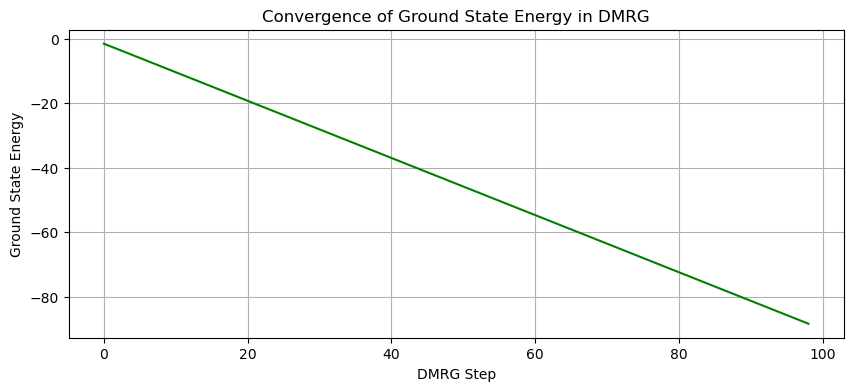

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(np.arange(0, len(energies)), energies[:], linestyle='-', color='green')
plt.xlabel('DMRG Step')
plt.ylabel('Ground State Energy')
plt.title('Convergence of Ground State Energy in DMRG')
plt.grid(True)
plt.show()


   $$
   \frac{E_0}{L} = -\frac{J}{4} - \frac{\ln(2) J}{\pi}
   $$
